<a href="https://colab.research.google.com/github/cytoscape/cytoscape-automation/blob/master/for-scripters/Python/differentially-expressed-genes-network-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differentially Expressed Genes Network Analysis
## Yihang Xin and Alex Pico
## 2021-11-05

This protocol describes a network analysis workflow in Cytoscape for a set of differentially expressed genes. Points covered:

* Retrieving relevant networks from public databases
* Network functional enrichment analysis
* Integration and visualization of experimental data
* Exporting network visualizations


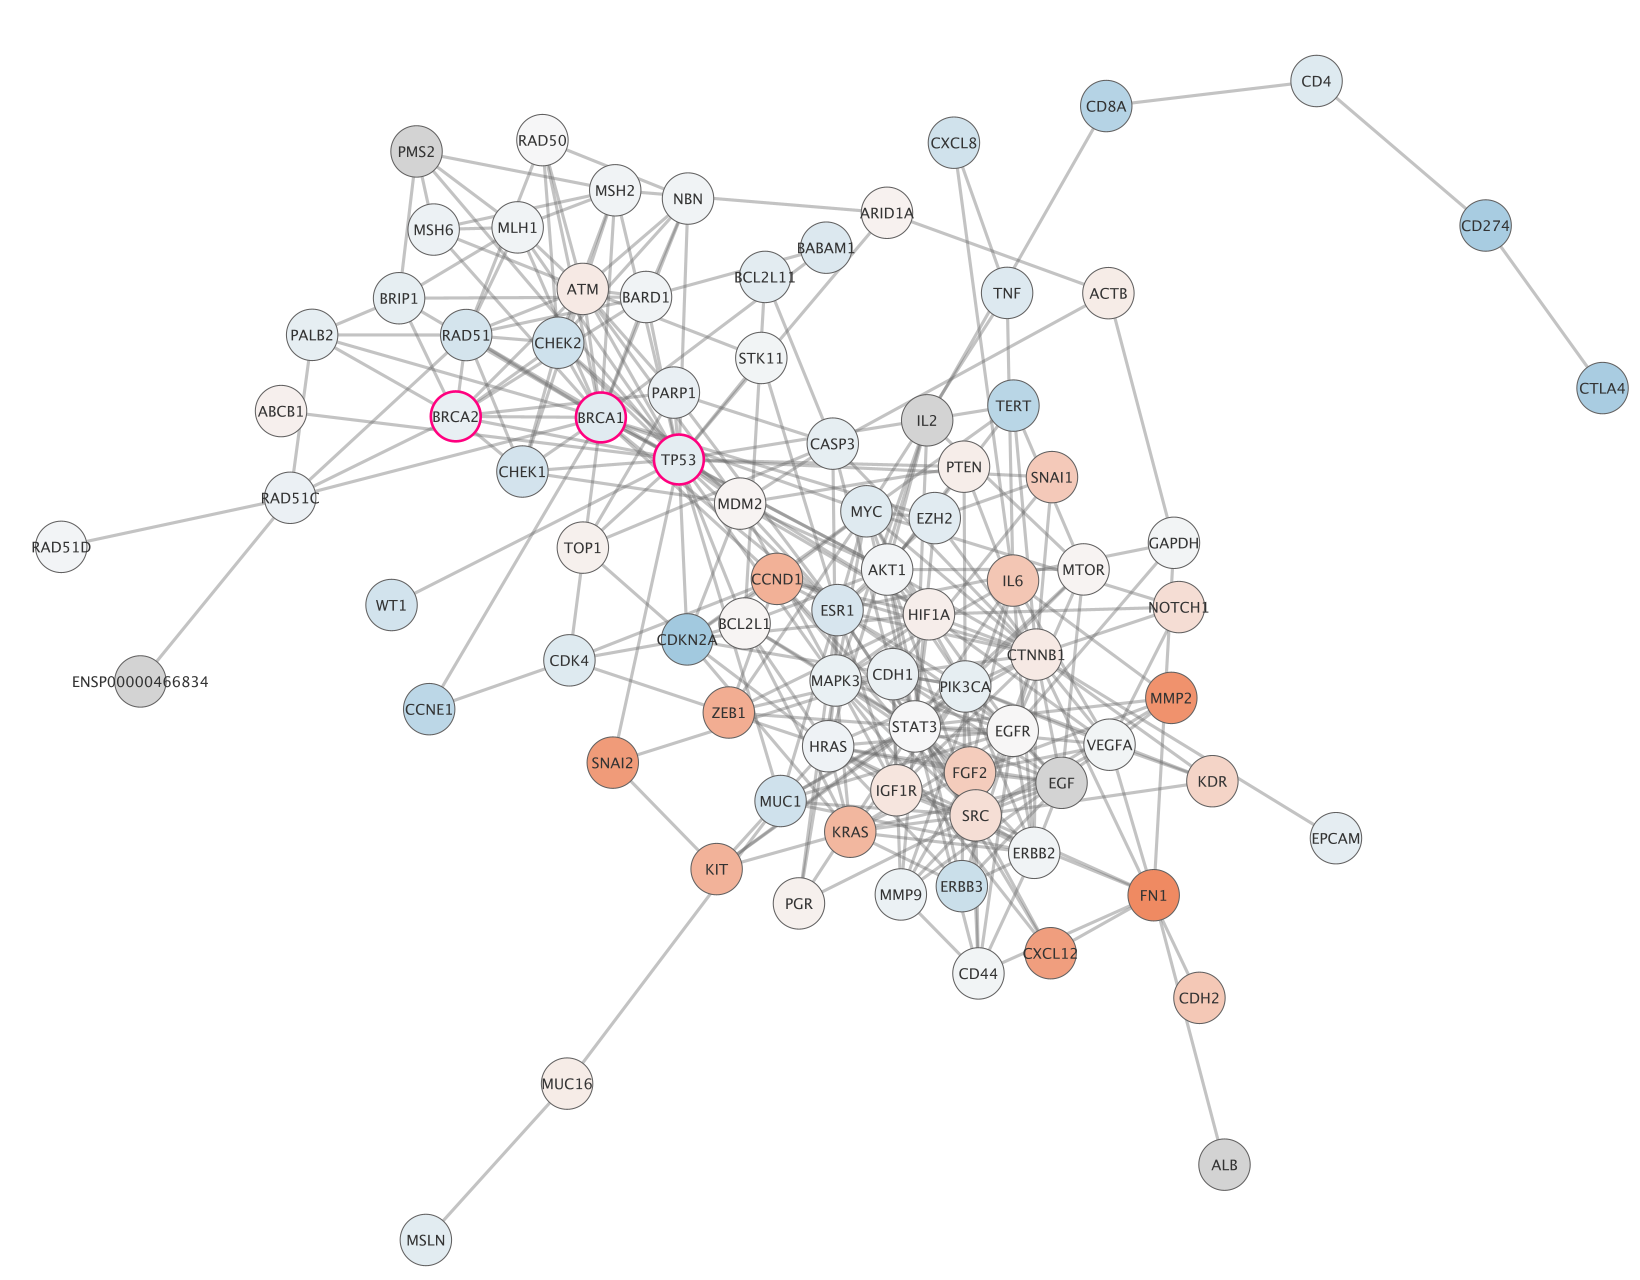

# Installation
The following chunk of code installs the `py4cytoscape` module.

In [ ]:
%%capture
!python3 -m pip install python-igraph requests pandas networkx
!python3 -m pip install py4cytoscape

If you are using a remote notebook environment such as Google Colab, please execute the cell below. (If you're running on your local notebook, you don't need to do that.)



In [ ]:
import requests
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


Loading Javascript client ... 36035c5c-62ae-4dfb-90ca-0ff92df44f10 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

# Prerequisites
## In addition to this package (py4cytoscape latest version 0.0.11), you will need:

* Latest version of Cytoscape, which can be downloaded from https://cytoscape.org/download.html. Simply follow the installation instructions on screen.
* Complete installation wizard
* Launch Cytoscape

For this notebook, you’ll also need the STRING app. 

Install the STRING app from https://apps.cytoscape.org/apps/stringapp

Install the filetransfer app from https://apps.cytoscape.org/apps/filetransfer

You can also install app inside Python notebook by running py4cytoscape.install_app('Your App')

# Background
Ovarian serous cystadenocarcinoma is a type of epithelial ovarian cancer which accounts for ~90% of all ovarian cancers. The data used in this protocol are from The Cancer Genome Atlas, in which multiple subtypes of serous cystadenocarcinoma were identified and characterized by mRNA expression.

We will focus on the differential gene expression between two subtypes, Mesenchymal and Immunoreactive.

For convenience, the data has already been analyzed and pre-filtered, using log fold change value and adjusted p-value.



# Network Retrieval
Many public databases and multiple Cytoscape apps allow you to retrieve a network or pathway relevant to your data. For this workflow, we will use the STRING app. Some other options include:

* WikiPathways
* NDEx
* GeneMANIA


# Retrieve Networks from STRING
To identify a relevant network, we will query the STRING database in two different ways:

* Query STRING protein with the list of differentially expressed genes.
* Query STRING disease for a keyword; ovarian cancer.
The two examples are split into two separate workflows below.

# Import the required package

In [ ]:
import os
import sys
import pandas as pd
import py4cytoscape as p4c
pd.options.mode.chained_assignment = None

# Setup Cytoscape

In [ ]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.0',
 'automationAPIVersion': '1.2.0',
 'py4cytoscapeVersion': '0.0.10'}

# Example 1: STRING Protein Query Up-regulated Genes

* Load the file containing the data for up-regulated genes, TCGA-Ovarian-MesenvsImmuno_UP_full.csv:


In [ ]:
tcga_url = 'https://raw.githubusercontent.com/cytoscape/cytoscape-tutorials/gh-pages/protocols/data/TCGA-Ovarian-MesenvsImmuno-data-up.csv'
tcga_df = pd.read_csv(tcga_url, sep = "\t")
tcga_df.head()

Gene     logFC  FDR adjusted Pvalue
0  9543  6.086663         7.110000e-33
1   165  2.119808         3.260000e-30
2  2200  2.110410         1.210000e-29
3  1307  1.870070         2.530000e-29
4   633  1.863731         2.530000e-29

* We will use the identifiers in the first column of this datafile to run a STRING protein query, with confidence (score) cutoff of 0.4:

In [ ]:
tcga_str = ','.join(str(v) for v in tcga_df["Gene"])

In [ ]:
string_cmd_list = ['string protein query','query="',tcga_str,'"', 'species="Homo sapiens"', 'cutoff=0.4']

In [ ]:
string_cmd = " ".join(string_cmd_list)

In [ ]:
p4c.commands.commands_run(string_cmd)

["Loaded network 'STRING network' with 202 nodes and 928 edges"]

The resulting network will load automatically and contains up-regulated genes recognized by STRING, and interactions between them with an evidence score of 0.4 or greater.

We will select only the connected nodes to work with for the rest of this tutorial, by creating a subnetwork based on all edges:

In [ ]:
p4c.create_subnetwork(edges='all', subnetwork_name='String de genes up')

69961

# Data Integration
Next we will import log fold changes and p-values from our TCGA dataset to create a visualization. Since the STRING network is a protein-protein network, it is annotated with protein identifiers (Uniprot and Ensembl protein), as well as HGNC gene symbols. Our data from TCGA has NCBI Gene identifiers (formerly Entrez), so before importing the data we are going to use the ID Mapper functionality in Cytoscape to map the network to NCBI Gene.

In [ ]:
mapped_cols = p4c.map_table_column('display name', 'Human', 'HGNC', 'Entrez Gene')

In [ ]:
full_url = 'https://raw.githubusercontent.com/cytoscape/cytoscape-tutorials/gh-pages/protocols/data/TCGA-Ovarian-MesenvsImmuno_data.csv'
full_df = pd.read_csv(full_url,  dtype={'Gene':str})
full_df.head()

Gene     logFC  FDR adjusted Pvalue
0   9543  6.086663         7.110000e-33
1  84168  1.647298         2.520000e-32
2    165  2.119808         3.260000e-30
3  23452  1.548527         1.180000e-29
4   2200  2.110410         1.210000e-29

In [ ]:
p4c.load_table_data(full_df, data_key_column='Gene', table_key_column='Entrez Gene')

'Success: Data loaded in defaultnode table'

In [ ]:
p4c.get_table_column_names('node')

['SUID',
 'shared name',
 'stringdb::canonical name',
 'display name',
 'stringdb::full name',
 'stringdb::database identifier',
 'stringdb::description',
 '@id',
 'stringdb::namespace',
 'stringdb::node type',
 'query term',
 'stringdb::sequence',
 'stringdb::species',
 'stringdb::STRING style',
 'stringdb::enhancedLabel Passthrough',
 'compartment::cytoskeleton',
 'compartment::cytosol',
 'compartment::endoplasmic reticulum',
 'compartment::endosome',
 'compartment::extracellular',
 'compartment::golgi apparatus',
 'compartment::lysosome',
 'compartment::mitochondrion',
 'compartment::nucleus',
 'compartment::peroxisome',
 'compartment::plasma membrane',
 'stringdb::interactor score',
 'stringdb::structures',
 'target::development level',
 'target::family',
 'tissue::adrenal gland',
 'tissue::blood',
 'tissue::bone',
 'tissue::bone marrow',
 'tissue::eye',
 'tissue::gall bladder',
 'tissue::heart',
 'tissue::intestine',
 'tissue::kidney',
 'tissue::liver',
 'tissue::lung',
 'tissue::

# Visualization
Next, we can create a visualization. Note that we can reuse most of the previous style (e.g., all the default settings) and just provide a new node color mapping with downregulated color scheme, like palette_color_brewer_s_Blues:

In [ ]:
p4c.set_visual_style('default')
p4c.set_node_shape_default('ELLIPSE', style_name='default')
p4c.lock_node_dimensions(True, style_name='default')
p4c.set_node_size_default(50, style_name='default')
p4c.set_node_color_default('#D3D3D3', style_name='default')
p4c.set_node_border_width_default(2, style_name='default')
p4c.set_node_color_default('#616060', style_name='default')
p4c.set_node_label_mapping('display name', style_name='default')
p4c.set_node_font_size_default(14, style_name='default')

''

In [ ]:
p4c.copy_visual_style('default', 'de genes up')
p4c.set_visual_style('de genes up')

{'message': 'Visual Style applied.'}

In [ ]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('logFC', p4c.palette_color_brewer_s_YlOrRd(), style_name='de genes up'))

''

Applying a force-directed layout, the network will now look something like this:



In [ ]:
p4c.layout_network('force-directed')

{}

# Enrichment Analysis Options
Next, we are going to perform enrichment anlaysis uing the STRING app.

# STRING Enrichment
The STRING app has built-in enrichment analysis functionality, which includes enrichment for GO Process, GO Component, GO Function, InterPro, KEGG Pathways, and PFAM.

First, we will run the enrichment on the whole network, against the genome:

In [ ]:
string_cmd = 'string retrieve enrichment allNetSpecies="Homo sapiens", background=genome  selectedNodesOnly="false"'
p4c.commands.commands_run(string_cmd)

['No results']

In [ ]:
string_cmd = 'string show enrichment'
p4c.commands.commands_run(string_cmd)

[]

When the enrichment analysis is complete, a new tab titled STRING Enrichment will open in the Table Panel.



The STRING app includes several options for filtering and displaying the enrichment results. The features are all available at the top of the STRING Enrichment tab.

We are going to filter the table to only show GO Process:

In [ ]:
string_cmd = 'string filter enrichment categories="GO Process", overlapCutoff = "0.5", removeOverlapping = "true"'
p4c.commands.commands_run(string_cmd)

['']

Next, we will add a split donut chart to the nodes representing the top terms:



In [ ]:
string_cmd = 'string show charts'
p4c.commands.commands_run(string_cmd)

[]

# STRING Protein Query: Down-regulated genes
We are going to repeat the network search, data integration, visualization and enrichment analysis for the set of down-regulated genes by using the first column of TCGA-Ovarian-MesenvsImmuno-data-down.csv:



In [ ]:
tcga_down_url = "https://cytoscape.github.io/cytoscape-tutorials/protocols/data/TCGA-Ovarian-MesenvsImmuno-data-down.csv"
tcga_down_df = pd.read_csv(tcga_down_url)
tcga_down_df.head()

Gene     logFC  FDR adjusted Pvalue
0    5698 -1.548465         4.710000e-17
1  115361 -1.587242         1.110000e-16
2    6890 -1.370056         1.360000e-16
3    5016 -4.479275         3.520000e-16
4  389903 -3.702067         1.590000e-15

In [ ]:
tcga_down_str = ','.join(str(v) for v in tcga_down_df["Gene"])

In [ ]:
string_cmd_list = ['string protein query','query="',tcga_down_str,'"', 'species="Homo sapiens"', 'cutoff=0.4']
string_cmd = " ".join(string_cmd_list)
p4c.commands.commands_run(string_cmd)

["Loaded network 'STRING network - 1' with 168 nodes and 717 edges"]

# Subnetwork
Let’s select only the connected nodes to work with for the rest of this tutorial, by creating a subnetwork based on all edges:

In [ ]:
p4c.create_subnetwork(edges='all', subnetwork_name='String de genes down')

79336

# Data integration
Again, the identifiers in the network needs to be mapped to Entrez Gene (NCBI gene):



In [ ]:
mapped_cols = p4c.map_table_column('display name', 'Human', 'HGNC', 'Entrez Gene')

In [ ]:
p4c.load_table_data(full_df, data_key_column='Gene', table_key_column='Entrez Gene')

'Success: Data loaded in defaultnode table'

# Visualization
Next, we can create a visualization. Note that the default style has been altered in the previous example, so we can simply switch to default to get started:

In [ ]:
p4c.set_visual_style('default')

{'message': 'Visual Style applied.'}

The node fill color has to be redefined for down-regulated genes:



In [ ]:
p4c.copy_visual_style('default', 'de genes down')
p4c.set_visual_style('de genes down')

{'message': 'Visual Style applied.'}

In [ ]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('logFC', p4c.palette_color_brewer_s_Blues(), style_name='de genes down'))

''

Apply a force-directed layout.



In [ ]:
p4c.layout_network('force-directed')

{}

# STRING Enrichment
Now we can perform STRING Enrichment analysis on the resulting network:

In [ ]:
string_cmd = 'string retrieve enrichment allNetSpecies="Homo sapiens", background=genome  selectedNodesOnly="false"'
p4c.commands.commands_run(string_cmd)

['No results']

Filter the analysis results for non-redundant GO Process terms only.

In [ ]:
string_cmd = 'string filter enrichment categories="GO Process", overlapCutoff = "0.5", removeOverlapping = "true"'
p4c.commands.commands_run(string_cmd)

['']

In [ ]:
string_cmd = 'string show charts'
p4c.commands.commands_run(string_cmd)

[]

# STRING Disease Query
So far, we queried the STRING database with a set of genes we knew were differentially expressed. Next, we will query the STRING disease database to retrieve a network genes associated with ovarian cancer, which will be completely independent of our dataset.

In [ ]:
string_cmd = 'string disease query disease="ovarian cancer" cutoff="0.95"'
p4c.commands.commands_run(string_cmd)

["Loaded network 'STRING network - ovarian cancer' with 100 nodes and 333 edges"]

This will bring in the top 100 (default) ovarian cancer associated genes connected with a confidence score greater than 0.95. Again, lets extract out the connected nodes:

In [ ]:
p4c.create_subnetwork(edges='all', subnetwork_name='String ovarian sub')

85411

# Data integration
Next we will import differential gene expression data from our TCGA dataset to create a visualization. Just like the previous example, we will need to do some identifier mapping to match the data to the network.

In [ ]:
mapped_cols = p4c.map_table_column('display name', 'Human', 'HGNC', 'Entrez Gene')

Here we set Human as species, HGNC as Map from, and Entrez Gene as To.

We can now import the data frame with the full data (already loaded the data in Example 1 above) into the node table in Cytoscape:

In [ ]:
p4c.load_table_data(full_df, data_key_column='Gene', table_key_column='Entrez Gene')

'Success: Data loaded in defaultnode table'

# Visualization
Again, we can create a visualization:

In [ ]:
p4c.set_visual_style('default')

{'message': 'Visual Style applied.'}

Let’s create the mapping:



In [ ]:
p4c.copy_visual_style('default', 'ovarian')
p4c.set_visual_style('ovarian')

{'message': 'Visual Style applied.'}

In [ ]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('logFC', p4c.palette_color_brewer_d_RdBu(), style_name='ovarian'))

''

Apply a force-directed layout.



In [ ]:
p4c.layout_network('force-directed')

{}

The TCGA found several genes that were commonly mutated in ovarian cancer, so called “cancer drivers”. We can add information about these genes to the network visualization, by changing the visual style of these nodes. Three of the most important drivers are TP53, BRCA1 and BRCA2. We will add a thicker, colored border for these genes in the network.

Select all three driver genes by:

In [ ]:
p4c.select_nodes(["TP53", "BRCA1", "BRCA2"], by_col='display name')

{'nodes': [83376, 83265, 83412], 'edges': []}

Add a style bypass for node Border Width (5) and node Border Paint (bright pink):


In [ ]:
p4c.set_node_border_width_bypass(p4c.get_selected_nodes(), 5)
p4c.set_node_border_color_bypass(p4c.get_selected_nodes(), '#FF007F')

''

# Exporting Networks
Cytoscape provides a number of ways to export results and visualizations:

As an image:

In [ ]:
p4c.export_image('differentially-expressed-genes', type='PDF')

# Note: PNG, SVG, JPEG and PS are also supported
# p4c.export_image('differentially-expressed-genes', type='PNG')
# p4c.export_image('differentially-expressed-genes', type='JPEG')
# p4c.export_image('differentially-expressed-genes', type='SVG')
# p4c.export_image('differentially-expressed-genes', type='PS')

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/differentially-expressed-genes.pdf'}

To a public repository:

In [ ]:
# p4c.export_network_to_ndex('userid', 'password', True)

As a Cytoscape JSON file:

In [ ]:
p4c.export_network('differentially-expressed-genes','cyjs')

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/differentially-expressed-genes.cyjs'}